In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

from retrieval_base.retrieval import RetrievalRun, Retrieval
#import utils

In [2]:
from pathlib import Path

class RetrievalResults(RetrievalRun, Retrieval):

    def __init__(self, prefix):

        self.evaluation = True

        # Load the config file
        config = self._load_config(prefix)

        # Set up the load_components() method
        Retrieval.__init__(self, config, create_output_dir=False)

        # Load the components
        self.load_components(['ParamTable'])

        # Load the posterior and best-fit parameters
        self.posterior, self.bestfit_parameters = self._load_posterior_and_bestfit()

    def get_mean_scaled_uncertainty(self, mode='order', n_dets_per_order=3):
        """Get the mean scaled uncertainty for each order or chip."""

        if mode not in ['order', 'chip']:
            raise ValueError('mode must be either "order" or "chip"')

        # Load the components
        self.load_components(['LogLike', 'Cov'])

        sigma = []

        if mode == 'chip':
            for i in range(self.LogLike.n_chips):
                # Compute per chip
                sigma_i = np.nanmean(np.sqrt(self.Cov[i].cov[0]*self.LogLike.s_squared[i]))
                sigma.append(sigma_i)

        elif mode == 'order':
            # Compute per order
            idx_l = np.arange(0, self.LogLike.n_chips, n_dets_per_order)
            idx_h = idx_l + n_dets_per_order
            for i_l, i_h in zip(idx_l, idx_h):

                # Combine detector diagonals
                diag_i = []
                for i in range(i_l, i_h):
                    diag_i.append(self.Cov[i].cov[0]*self.LogLike.s_squared[i])
                
                sigma_i = np.nanmean(np.sqrt(np.concatenate(diag_i)))
                sigma.append(sigma_i)
        
        del self.LogLike, self.Cov
        
        return np.array(sigma)

    @staticmethod
    def _load_config(prefix):
        """Load the config file from the data directory."""

        import importlib

        # Find the file with .py suffix
        data_dir = Path(f'{prefix}data')
        print(data_dir)
        config_file = list(data_dir.glob('*.py'))
        if len(config_file) != 1:
            raise ValueError('There should be exactly one config file in the data directory')

        # Temporarily copy the config file to the current directory
        destination = Path('./tmp_config.py')
        destination.write_bytes(config_file[0].read_bytes())

        # Import the config file
        config = importlib.import_module('tmp_config')
        setattr(config, 'config_file', 'tmp_config.py')

        # Update to the full path
        config.prefix = prefix
        return config

    def _load_posterior_and_bestfit(self, posterior=None):
        """Load the posterior and best-fit parameters from the output files."""

        import pymultinest

        # Read the equally-weighted posterior
        analyzer = pymultinest.Analyzer(
            n_params=self.ParamTable.n_free_params, 
            outputfiles_basename=self.config.prefix
            )
        posterior = analyzer.get_equal_weighted_posterior()
        posterior = posterior[:,:-1]
        
        # Read best-fit parameters
        stats = analyzer.get_stats()
        bestfit_parameters = np.array(stats['modes'][0]['maximum a posterior'])
        
        return posterior, bestfit_parameters

Res_A = RetrievalResults('../retrieval_outputs/freechem_K_A_ret_2/test_')
Res_B = RetrievalResults('../retrieval_outputs/freechem_K_B_ret_2/test_')

../retrieval_outputs/freechem_K_A_ret_2/test_data
  analysing data from ../retrieval_outputs/freechem_K_A_ret_2/test_.txt
../retrieval_outputs/freechem_K_B_ret_2/test_data
  analysing data from ../retrieval_outputs/freechem_K_B_ret_2/test_.txt


## Observations

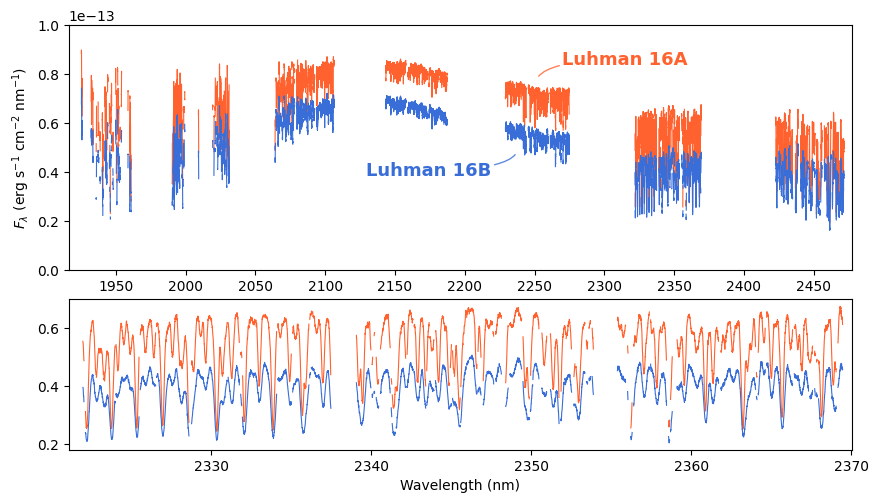

In [3]:
Res_A.load_components(['d_spec'])
Res_B.load_components(['d_spec'])

name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_m_A = '#FF622E'; color_m_B = '#396ED8'
color_A = '#FF622E'; color_B = '#396ED8'

lw_d = 0.8
lw_m = 1.0

scale = 1e-13
idx_chips = [15,16,17]

fig = plt.figure(figsize=(9,5))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.15, wspace=0, height_ratios=[0.62,(1-0.62)])
ax = np.array([fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])])

ax[0].plot(Res_A.d_spec['K2166_1'].wave.flatten(), Res_A.d_spec['K2166_1'].flux.flatten(), c=color_A, lw=lw_d)
ax[0].plot(Res_B.d_spec['K2166_1'].wave.flatten(), Res_B.d_spec['K2166_1'].flux.flatten(), c=color_B, lw=lw_d)

ax[1].plot(Res_A.d_spec['K2166_1'].wave[idx_chips].flatten(), Res_A.d_spec['K2166_1'].flux[idx_chips].flatten()/scale, c=color_A, lw=lw_d)
ax[1].plot(Res_B.d_spec['K2166_1'].wave[idx_chips].flatten(), Res_B.d_spec['K2166_1'].flux[idx_chips].flatten()/scale, c=color_B, lw=lw_d)

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(np.log10(scale), np.log10(scale)))
ax[0].set(xticks=np.arange(1900,2500+1,50))
ax[0].set(
    xlim=(Res_B.d_spec['K2166_1'].wave_ranges_chips.min()-5,Res_B.d_spec['K2166_1'].wave_ranges_chips.max()+5), 
    ylim=(0,1e-13), ylabel=r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', 
    )
ax[1].set(
    xlim=(Res_B.d_spec['K2166_1'].wave_ranges_chips[idx_chips].min()-0.5, Res_B.d_spec['K2166_1'].wave_ranges_chips[idx_chips].max()+0.5), 
    xlabel=r'Wavelength (nm)'
    )

ax[0].annotate(
    name_A, xy=(0.6,0.79), xytext=(0.63,0.82), xycoords='axes fraction', ha='left', va='bottom', c=color_A, fontsize=13, fontweight='bold',  
    arrowprops={'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=50', 'shrinkA':0, 'shrinkB':0, 'lw':1, 'color':color_A, 'alpha':0.8}, 
    )
ax[0].annotate(
    name_B, xy=(0.57,0.47), xytext=(0.54,0.37), xycoords='axes fraction', ha='right', va='bottom', c=color_B, fontsize=13, fontweight='bold',
    arrowprops={'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=50','shrinkA':0, 'shrinkB':0, 'lw':1, 'color':color_B, 'alpha':0.8}, 
    )

plt.subplots_adjust(left=0.09, bottom=0.10, top=0.95, right=0.96)
plt.savefig('./plots/K_band_spectrum.pdf')
plt.show()

## Best-fitting model

In [4]:
sigma_A = Res_A.get_mean_scaled_uncertainty(mode='order')
sigma_B = Res_B.get_mean_scaled_uncertainty(mode='order')

Res_A.load_components(['LogLike'])
Res_B.load_components(['LogLike'])

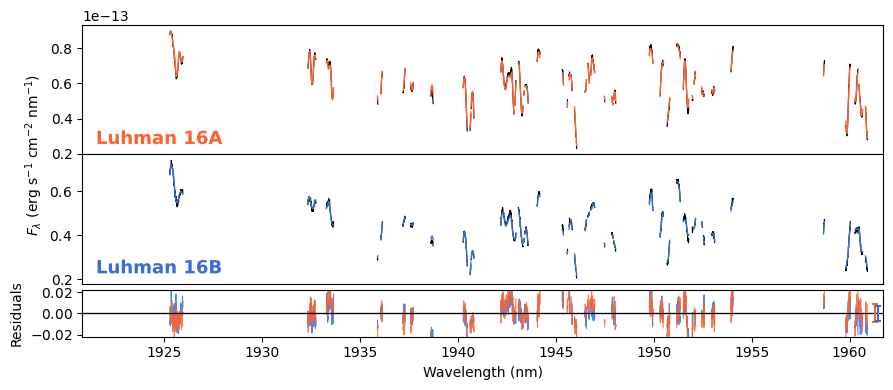

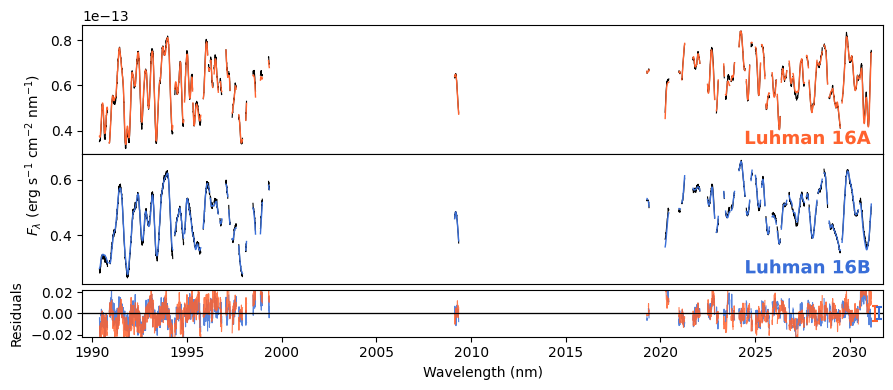

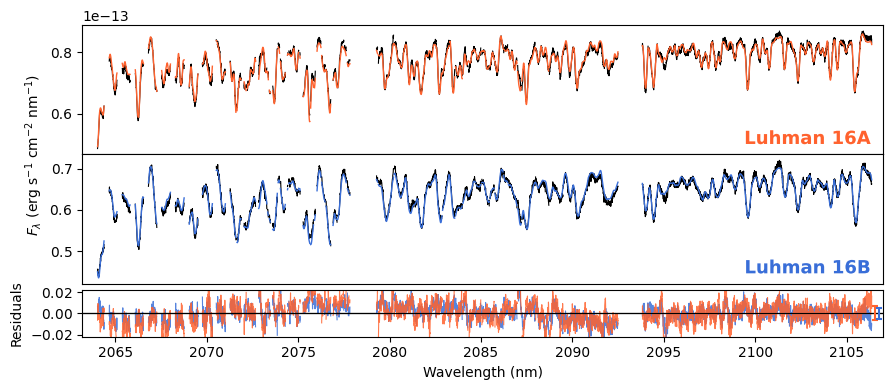

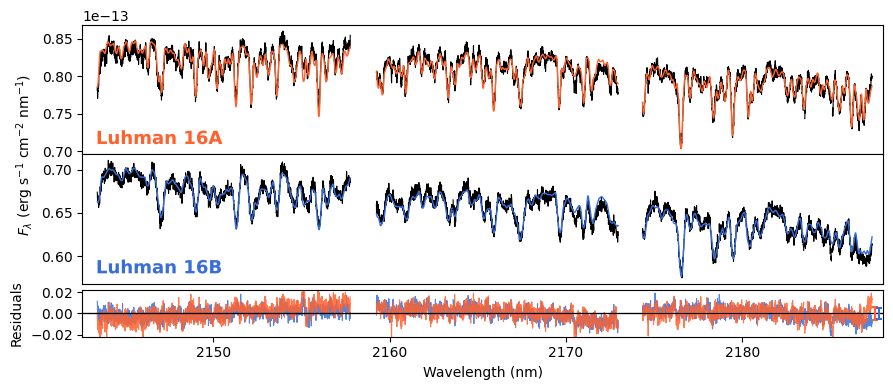

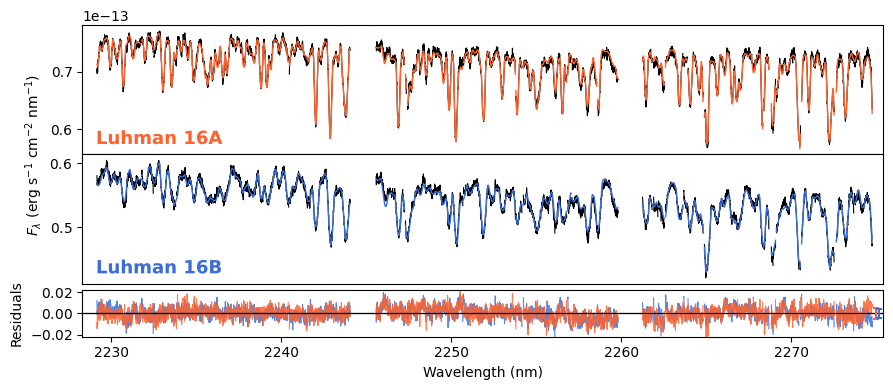

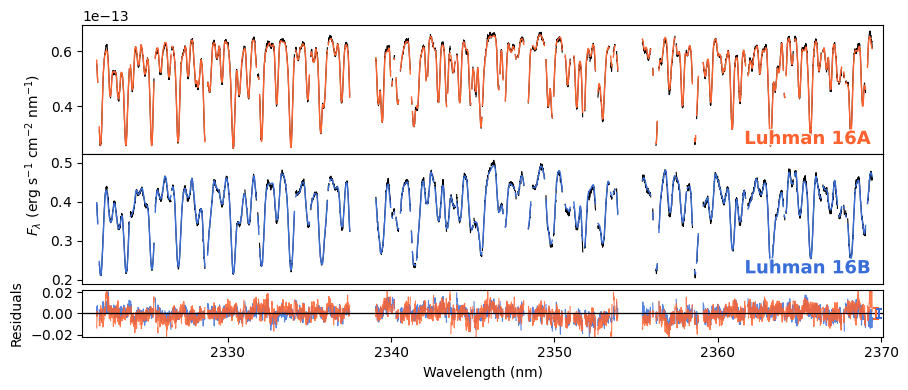

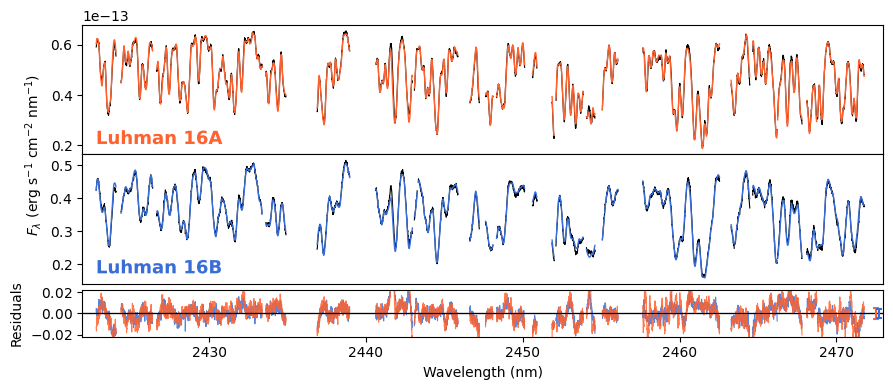

In [36]:
res_alpha = 0.85

idx_chips = np.arange(Res_A.LogLike.n_chips, dtype=int).reshape(-1,3)
for i, idx in enumerate(idx_chips):

    fig = plt.figure(figsize=(9,3.8))
    gs = fig.add_gridspec(nrows=4, ncols=1, hspace=0.0, wspace=0, height_ratios=[(0.85-0.02)/2,(0.85-0.02)/2,0.02,0.15])
    ax = np.array([fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0]), fig.add_subplot(gs[3,0])])

    for j in idx:
        mask = np.ones_like(Res_A.d_spec['K2166_1'].flux[j])
        mask[np.isnan(Res_A.d_spec['K2166_1'].flux[j])] = np.nan

        ax[0].plot(Res_A.d_spec['K2166_1'].wave[j], Res_A.d_spec['K2166_1'].flux[j], c='k', lw=lw_d)
        ax[0].plot(Res_A.d_spec['K2166_1'].wave[j], Res_A.LogLike.m_flux_phi[j]*mask, c=color_A, lw=lw_m)

        ax[1].plot(Res_B.d_spec['K2166_1'].wave[j], Res_B.d_spec['K2166_1'].flux[j]/scale, c='k', lw=lw_d)
        ax[1].plot(Res_B.d_spec['K2166_1'].wave[j], Res_B.LogLike.m_flux_phi[j]*mask/scale, c=color_B, lw=lw_m)

        ax[2].plot(Res_B.d_spec['K2166_1'].wave[j], (Res_B.d_spec['K2166_1'].flux[j]-Res_B.LogLike.m_flux_phi[j])*mask/scale, c=color_B, lw=lw_d, alpha=res_alpha)
        ax[2].plot(Res_A.d_spec['K2166_1'].wave[j], (Res_A.d_spec['K2166_1'].flux[j]-Res_A.LogLike.m_flux_phi[j])*mask/scale, c=color_A, lw=lw_d, alpha=res_alpha)
        ax[2].axhline(0.0, c='k', lw=ax[2].spines['left'].get_lw())

    xlim = (
        Res_A.d_spec['K2166_1'].wave_ranges_chips[idx].min()-0.5, 
        Res_A.d_spec['K2166_1'].wave_ranges_chips[idx].max()+0.6
        )

    for j, ax_j in enumerate(ax):
        if j < len(ax)-1:
            ax_j.set_xticks([])
            ylim = None
        else:
            ylim = (-0.022,0.022)
        ax_j.set(xlim=xlim, ylim=ylim)

    # Errorbars
    ax[2].errorbar(xlim[1]-0.45, 0, yerr=sigma_A[i]/scale, c=color_A, capsize=2, lw=1.5, capthick=1.5)
    ax[2].errorbar(xlim[1]-0.25, 0, yerr=sigma_B[i]/scale, c=color_B, capsize=2, lw=1.5, capthick=1.5)

    # Axis ticks
    ax[0].ticklabel_format(axis='y', style='sci', scilimits=(np.log10(scale),np.log10(scale)))

    decimals0 = []
    for label_i in ax[0].get_yticklabels():
        if len(label_i.get_text().rsplit('.')) == 1:
            decimals0.append(0)
        else:
            decimals0.append(len(label_i.get_text().rsplit('.')[1]))

    decimals1 = []
    for label_i in ax[1].get_yticklabels():
        if len(label_i.get_text().rsplit('.')) == 1:
            decimals1.append(0)
        else:
            decimals1.append(len(label_i.get_text().rsplit('.')[1]))

    decimals = max([*decimals0,*decimals1])
    decimals = max([*decimals0])

    ax[1].yaxis.set_major_formatter(FormatStrFormatter(r'$%.'+str(decimals)+'f$'))
    ax[-1].yaxis.set_major_formatter(FormatStrFormatter(r'$%.2f$'))

    # Labels
    ha='left'; xy=(0.017,0.05)
    if i in [1,2,5]:
        ha='right'; xy=(1-0.017,0.05)
    ax[0].annotate(
        name_A, xy=xy, xycoords='axes fraction', ha=ha, va='bottom', c=color_A, fontsize=13, 
        fontweight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.8)]
        )
    ax[1].annotate(
        name_B, xy=xy, xycoords='axes fraction', ha=ha, va='bottom', c=color_B, fontsize=13, 
        fontweight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.8)]
        )

    # Axis labels
    ax[0].set_ylabel(r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', y=0)
    ax[-1].set(xlabel=r'Wavelength (nm)', ylabel='Residuals')

    plt.subplots_adjust(left=0.09, bottom=0.12, top=0.94, right=0.98)
    plt.savefig(f'./plots/K_band_spectrum_bestfit_order{i}.pdf')
    plt.show()
    plt.close()